In [1]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import math
import random
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve
from statannot import add_stat_annotation
import seaborn as sns
import time
import matplotlib.pyplot as plt

from tqdm import tqdm
import sklearn
import seaborn as sns
from matplotlib.offsetbox import AnchoredText
from lifelines import KaplanMeierFitter, CoxPHFitter, calibration
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts
from scipy.stats import wilcoxon
import scipy.stats as st

In [2]:
test_data = pd.read_csv("logs/test_set.csv")
external_data = pd.read_csv("logs/external_set.csv")

# AUC Plot Function

In [3]:
def bootstrap_results(y_truth, y_pred,num_bootstraps = 1000):
    n_bootstraps = num_bootstraps
    rng_seed = 42  # control reproducibility
    y_pred=y_pred
    y_true=y_truth
    rng = np.random.RandomState(rng_seed)
    tprs=[]
    fprs=[]
    aucs=[]
    threshs=[]
    base_thresh = np.linspace(0, 1, 101)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            continue
        fpr, tpr, thresh = metrics.roc_curve(y_true[indices],y_pred[indices])
        thresh=thresh[1:]
        thresh=np.append(thresh,[0.0])
        thresh=thresh[::-1]
        fpr = np.interp(base_thresh, thresh, fpr[::-1])
        tpr = np.interp(base_thresh, thresh, tpr[::-1])
        tprs.append(tpr)
        fprs.append(fpr)
        threshs.append(thresh)
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)  
    fprs = np.array(fprs)
    mean_fprs = fprs.mean(axis=0)
    
    return base_thresh, mean_tprs, mean_fprs

def get_auc_ci(y_truth, y_pred,num_bootstraps = 1000):
    n_bootstraps = num_bootstraps
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []
    y_pred=y_pred
    y_true=y_truth
    rng = np.random.RandomState(rng_seed)
    tprs=[]
    aucs=[]
    base_fpr = np.linspace(0, 1, 101)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            continue
        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
        fpr, tpr, _ = metrics.roc_curve(y_true[indices],y_pred[indices])
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)
    mean_auc = metrics.auc(base_fpr, mean_tprs)
    std_auc = np.std(aucs)
    tprs_upper = np.minimum(mean_tprs + std*2, 1)
    tprs_lower = mean_tprs - std*2
    return base_fpr, mean_tprs, tprs_lower, tprs_upper, mean_auc, std_auc

def plot_auc(truth, reference_model_1, reference_model_2, new_model,n_bootstraps=1000, save=False, fig_name=""):
    col1 = '#91D1C2FF'
    col2 = '#3C5488FF'
    col3 = '#EE00007F'
    
    y_truth = truth
    ref_model_1 = reference_model_1
    ref_model_2 = reference_model_2
    new_model = new_model
    ref_fpr_1, ref_tpr_1, ref_thresholds_1 = metrics.roc_curve(y_truth, ref_model_1)
    ref_fpr_2, ref_tpr_2, ref_thresholds_2 = metrics.roc_curve(y_truth, ref_model_2)
    
    new_fpr, new_tpr, new_thresholds = metrics.roc_curve(y_truth, new_model)
    ref_auc_1, ref_auc_2, new_auc = metrics.auc(ref_fpr_1, ref_tpr_1), metrics.auc(ref_fpr_2, ref_tpr_2),metrics.auc(new_fpr, new_tpr)
  
    base_fpr_ref_1, mean_tprs_ref_1, tprs_lower_ref_1, tprs_upper_ref_1, mean_auc_ref_1, std_auc_ref_1=get_auc_ci(y_truth, ref_model_1,n_bootstraps)
    base_fpr_ref_2, mean_tprs_ref_2, tprs_lower_ref_2, tprs_upper_ref_2, mean_auc_ref_2, std_auc_ref_2=get_auc_ci(y_truth, ref_model_2,n_bootstraps)
    base_fpr_new, mean_tprs_new, tprs_lower_new, tprs_upper_new, mean_auc_new, std_auc_new=get_auc_ci(y_truth, new_model,n_bootstraps)

    
    plt.figure(figsize=(8, 8))
    lw = 3
#     plt.plot(ref_fpr_1, ref_tpr_1, color='blue',
#              lw=lw, label='TNM model (AUC = %0.3f)' % ref_auc_1, linestyle='--')
    plt.plot(base_fpr_ref_1, mean_tprs_ref_1, col1, alpha = 1, linewidth = lw, label=r'TNM ROC (AUC=%0.3f, CI=%0.3f-%0.3f)' % (mean_auc_ref_1, (mean_auc_ref_1-2*std_auc_ref_1),(mean_auc_ref_1+2*std_auc_ref_1)),)
#     plt.fill_between(base_fpr_ref_1, tprs_lower_ref_1, tprs_upper_ref_1, color = col1, alpha = 0.2)
    
#     plt.plot(ref_fpr_2, ref_tpr_2, color='yellow',
#              lw=lw, label='ResNet-Graph ROC (AUC = %0.3f)' % ref_auc_2, linestyle='--')
    plt.plot(base_fpr_ref_2, mean_tprs_ref_2, col2, alpha = 1, linewidth = lw, label=r'ResNet-Graph ROC (AUC=%0.3f, CI=%0.3f-%0.3f)' % (mean_auc_ref_2, (mean_auc_ref_2-2*std_auc_ref_2),(mean_auc_ref_2+2*std_auc_ref_2)),)
#     plt.fill_between(base_fpr_ref_2, tprs_lower_ref_2, tprs_upper_ref_2, color = col2, alpha = 0.2)
    
#     plt.plot(new_fpr, new_tpr, color='darkorange',
#              lw=lw, label='Transformer-GNN  ROC (AUC = %0.3f)' % new_auc, linestyle='--')
    plt.plot(base_fpr_new, mean_tprs_new, col3, alpha = 1, linewidth = lw, label=r'Transformer-Graph ROC (AUC=%0.3f, CI=%0.3f-%0.3f)' % (mean_auc_new,(mean_auc_new-2*std_auc_new),(mean_auc_new+2*std_auc_new)),)
#     plt.fill_between(base_fpr_new, tprs_lower_new, tprs_upper_new, color = col3, alpha = 0.2)
    plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('1 - Specificity', fontsize=16)
    plt.ylabel('Sensitivity', fontsize=16)
    plt.legend(loc="lower right", fontsize=13)
    plt.gca().set_aspect('equal', adjustable='box')
    if save:
        save_path = "logs/figures/"+fig_name+".png"
        plt.savefig(save_path, dpi=350)

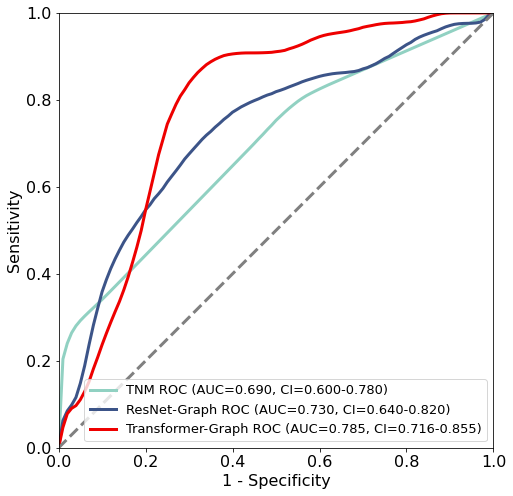

In [18]:
plot_auc(test_data['OS_Status'], reference_model_1= test_data['TNM_risk'], reference_model_2= test_data['ResNet_risk'], new_model=test_data['risk'],n_bootstraps=1000, save=True, fig_name="testAUC")

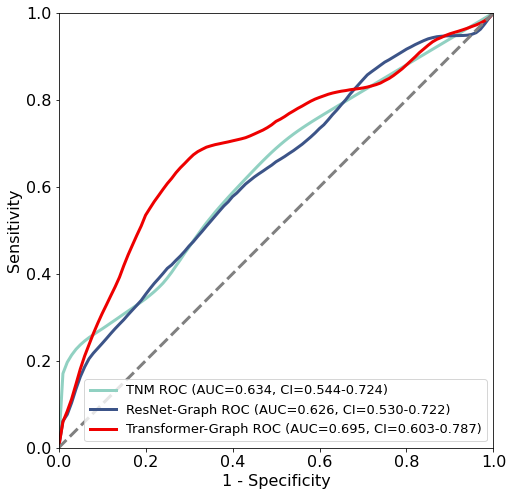

In [19]:
plot_auc(external_data['OS_Status'], reference_model_1= external_data['TNM_risk'], reference_model_2= external_data['ResNet_risk'], new_model=external_data['risk'],n_bootstraps=1000, save=True, fig_name="externalAUC")

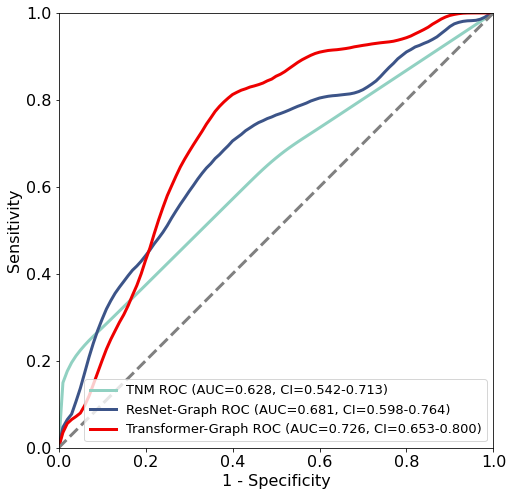

In [20]:
plot_auc(test_data['RFS_Status'], reference_model_1= test_data['TNM_risk'], reference_model_2= test_data['ResNet_risk'], new_model=test_data['risk'],n_bootstraps=1000, save=True, fig_name="RFS_testAUC")

In [4]:
rfs = []
for i in range(len(external_data['RFS_Status'])):
    if external_data['OS_Status'][i] == 1 and external_data['RFS_Status'][i] == 0:
        rfs.append(1)
    else:
        rfs.append(external_data['RFS_Status'][i])
        
external_data['new_RFS'] = rfs

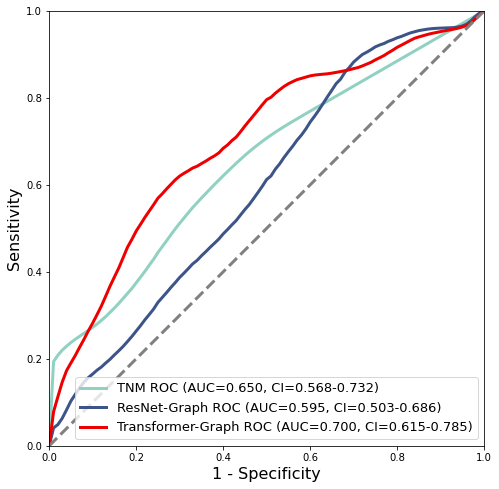

In [6]:
plot_auc(external_data['new_RFS'], reference_model_1= external_data['TNM_risk'], reference_model_2= external_data['ResNet_risk'], new_model=external_data['risk'],n_bootstraps=1000, save=True, fig_name="RFS_externalAUC")

# NRI functions

In [16]:
def check_cat(prob,thresholds):
    cat=0
    for i,v in enumerate(thresholds):
        if prob>v:
            cat=i
    return cat

def make_cat_matrix(ref, new, indices, thresholds):
    num_cats=len(thresholds)
    mat=np.zeros((num_cats,num_cats))
    for i in indices:
        row,col=check_cat(ref[i],thresholds),check_cat(new[i],thresholds)
        mat[row,col]+=1
    return mat
        
def nri(y_truth,y_ref, y_new,risk_thresholds):
    event_index = np.where(y_truth==1)[0]
    nonevent_index = np.where(y_truth==0)[0]
    event_mat=make_cat_matrix(y_ref,y_new,event_index,risk_thresholds)
    nonevent_mat=make_cat_matrix(y_ref,y_new,nonevent_index,risk_thresholds)
    events_up, events_down = event_mat[0,1:].sum()+event_mat[1,2:].sum()+event_mat[2,3:].sum(),event_mat[1,:1].sum()+event_mat[2,:2].sum()+event_mat[3,:3].sum()
    nonevents_up, nonevents_down = nonevent_mat[0,1:].sum()+nonevent_mat[1,2:].sum()+nonevent_mat[2,3:].sum(),nonevent_mat[1,:1].sum()+nonevent_mat[2,:2].sum()+nonevent_mat[3,:3].sum()
    nri_events = (events_up/len(event_index))-(events_down/len(event_index))
    nri_nonevents = (nonevents_down/len(nonevent_index))-(nonevents_up/len(nonevent_index))
    return nri_events, nri_nonevents, nri_events + nri_nonevents 


def track_movement(ref,new, indices):
    up, down = 0,0
    for i in indices:
        ref_val, new_val = ref[i],new[i]
        if ref_val<new_val:
            up+=1
        elif ref_val>new_val:
            down+=1
    return up, down

def category_free_nri(y_truth,y_ref, y_new):
    event_index = np.where(y_truth==1)[0]
    nonevent_index = np.where(y_truth==0)[0]
    events_up, events_down = track_movement(y_ref, y_new,event_index)
    nonevents_up, nonevents_down = track_movement(y_ref, y_new,nonevent_index)
    nri_events = (events_up/len(event_index))-(events_down/len(event_index))
    nri_nonevents = (nonevents_down/len(nonevent_index))-(nonevents_up/len(nonevent_index))
    return nri_events, nri_nonevents, nri_events + nri_nonevents 

In [18]:
category_free_nri(test_data['OS_Status'], test_data['TNM'],test_data['risk_labels'])

(0.13636363636363635, 0.17751479289940825, 0.3138784292630446)

In [ ]:
category_free_nri(test_data['OS_Status'], test_data['TNM'],test_data['risk_labels'])

In [7]:
def area_between_curves(y1,y2):
    diff = y1 - y2 # calculate difference
    posPart = np.maximum(diff, 0) 
    negPart = -np.minimum(diff, 0) 
    posArea = np.trapz(posPart)
    negArea = np.trapz(negPart)
    return posArea,negArea,posArea-negArea

def plot_idi(y_truth, ref_model, new_model, save=False): 
    ref_fpr, ref_tpr, ref_thresholds = metrics.roc_curve(y_truth, ref_model)
    new_fpr, new_tpr, new_thresholds = metrics.roc_curve(y_truth, new_model)
    base, mean_tprs, mean_fprs=bootstrap_results( y_truth, new_model,100)
    base2, mean_tprs2, mean_fprs2=bootstrap_results( y_truth, ref_model,100)
    is_pos,is_neg, idi_event=area_between_curves(mean_tprs,mean_tprs2)
    ip_pos,ip_neg, idi_nonevent=area_between_curves(mean_fprs2,mean_fprs)
    print('IS positive', round(is_pos,2),'IS negative',round(is_neg,2),'IDI events',round(idi_event,2))
    print('IP positive', round(ip_pos,2),'IP negative',round(ip_neg,2),'IDI nonevents',round(idi_nonevent,2))
    print('IDI =',round(idi_event+idi_nonevent,2))
    plt.figure(figsize=(10, 10))
    ax=plt.axes()
    lw = 2
    plt.plot(base, mean_tprs, 'black', alpha = 0.5, label='Events New (New)' )
    plt.plot(base, mean_fprs, 'red', alpha = 0.5, label='Nonevents New (New)')
    plt.plot(base2, mean_tprs2, 'black', alpha = 0.7, linestyle='--',label='Events Reference (Ref)' )
    plt.plot(base2, mean_fprs2, 'red', alpha = 0.7,  linestyle='--', label='Nonevents Reference (Ref)')
    plt.fill_between(base, mean_tprs,mean_tprs2, color='black',alpha = 0.1, label='Integrated Sensitivity (area = %0.2f)'%idi_event)
    plt.fill_between(base, mean_fprs,mean_fprs2, color='red', alpha = 0.1, label='Integrated Specificity (area = %0.2f)'%idi_nonevent)
    
    #''' #TODO: comment out if not for breast birads
    ### BIRADS Thresholds ###
    plt.axvline(x=0.02,color='darkorange',linestyle='--',alpha=.5,label='BI-RADS 3/4a Border (2%)')
    plt.axvline(x=0.10,color='green',linestyle='--',alpha=.5,label='BI-RADS 4a/4b Border (10%)')
    plt.axvline(x=0.5,color='blue',linestyle='--',alpha=.5,label='BI-RADS 4b/4c Border (50%)')
    plt.axvline(x=0.95,color='purple',linestyle='--',alpha=.5,label='BI-RADS 4c/5 Border (95%)')
    def nri_annotation(plt, threshold):
        x_pos = base[threshold]
        x_offset=0.02
        x_offset2=x_offset
        text_y_offset=0.01
        text_y_offset2=text_y_offset
        if threshold==2:
            text_y_offset=0.04
            text_y_offset2=0.04
            x_offset2=0.05
            print("=====================")
            print(x_pos+x_offset, (np.mean([mean_tprs2[threshold], mean_tprs[threshold]])+text_y_offset),
                    x_pos, (np.mean([mean_tprs2[threshold], mean_tprs[threshold]])))
            print("=====================")
            
        text_y_events=np.mean([mean_tprs2[threshold], mean_tprs[threshold]])+text_y_offset
        text_y_nonevents=np.mean([mean_fprs[threshold], mean_fprs2[threshold]])+text_y_offset2
        plt.annotate('', xy=(x_pos+0.02, mean_tprs2[threshold+1]), xycoords='data', xytext=(x_pos+0.02, 
                            mean_tprs[threshold]), textcoords='data', arrowprops={'arrowstyle': '|-|'})
        plt.annotate('NRI$_{events}$ = %0.2f'%(mean_tprs[threshold]-mean_tprs2[threshold]), 
                     xy=(x_pos+x_offset, text_y_events), xycoords='data',
                     xytext=(x_pos+x_offset, text_y_events),
                     textcoords='offset points', fontsize=15)
        plt.annotate('', xy=(x_pos+0.02, mean_fprs[threshold]), xycoords='data', xytext=(x_pos+0.02, 
                             mean_fprs2[threshold]), textcoords='data', arrowprops=dict(arrowstyle= '|-|',color='r'))
        plt.annotate('NRI$_{nonevents}$ = %0.2f'%(mean_fprs2[threshold]-mean_fprs[threshold]), 
                     xy=(x_pos+x_offset2, text_y_nonevents), xycoords='data',
                     xytext=(x_pos+x_offset2, text_y_nonevents), 
                     textcoords='offset points', fontsize=15)
        print('Threshold =',round(x_pos,2),'NRI events =',round(mean_tprs[threshold]-mean_tprs2[threshold],4),
              'NRI nonevents =',round(mean_fprs2[threshold]-mean_fprs[threshold],4),'Total =',
              round((mean_tprs[threshold]-mean_tprs2[threshold])+(mean_fprs2[threshold]-mean_fprs[threshold]),4))
    nri_annotation(plt,2)
    nri_annotation(plt,10)
    nri_annotation(plt,50)
    nri_annotation(plt,95)
    #'''
    plt.xlim([0.0, 1.10])
    plt.ylim([0.0, 1.10])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlabel('Calculated Risk', fontsize=18)
    plt.ylabel('Sensitivity (black), 1 - Specificity (red)', fontsize=18)
    plt.legend(loc="upper right", fontsize=11)
    plt.legend(loc=0, fontsize=11,  bbox_to_anchor=(0,0,1.2,.9))
    plt.gca().set_aspect('equal', adjustable='box')
    #if save:
    #    plt.savefig('idi_curve.png',dpi=300, bbox_inches='tight')
    look=95
    plt.show()
#plot_idi(y_test.values,test_pred[:,1],test_pred2[:,1])

IS positive 6.98 IS negative 0.0 IDI events 6.98
IP positive 8.88 IP negative 0.0 IDI nonevents 8.88
IDI = 15.86
0.04 0.8534312729659059 0.02 0.8134312729659059
Threshold = 0.02 NRI events = 0.1367 NRI nonevents = 0.1741 Total = 0.3108
Threshold = 0.1 NRI events = 0.1256 NRI nonevents = 0.1599 Total = 0.2855
Threshold = 0.5 NRI events = 0.0698 NRI nonevents = 0.0888 Total = 0.1586
Threshold = 0.95 NRI events = 0.007 NRI nonevents = 0.0089 Total = 0.0159


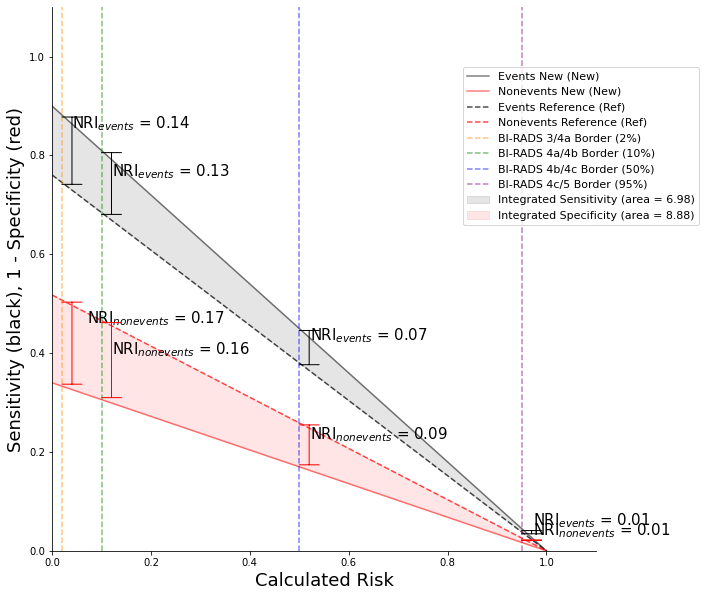

In [8]:
plot_idi(y_truth= test_data['OS_Status'],ref_model= test_data['TNM'],new_model= test_data['risk_labels'], save=False)

In [6]:
nri(y_truth= test_data['OS_Status'],ref_model= test_data['TNM'],new_model= test_data['risk_labels'],risk_thresholds)

SyntaxError: positional argument follows keyword argument (1209657827.py, line 1)